In [9]:
import os
import keras
import pickle
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.layers import BatchNormalization
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import zipfile
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras import models, layers, callbacks
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
from google.colab import drive
import matplotlib.pyplot as plt

In [10]:
#mount drive if necessary
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
# download dataset from kaggle
# upload .json of kaggle
! mkdir -p ~/.kaggle;
! cp kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d jessicali9530/celeba-dataset

100% 1.33G/1.33G [00:13<00:00, 187MB/s]
100% 1.33G/1.33G [00:13<00:00, 102MB/s]


In [12]:
#unzip the files
!unzip celeba-dataset.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: img_align_celeba/img_align_celeba/197604.jpg  
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/img_align_c

In [13]:
# Image Data Generator so we dont need to load all images the same time

# Define paths, change accordingly
image_directory = '/content/img_align_celeba/img_align_celeba'
csv_file = '/content/list_attr_celeba.csv'

# Load CSV file
df = pd.read_csv(csv_file)
df.replace(-1, 0, inplace=True)
print(df.columns)

# Split data into training, validation, and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

# Create separate ImageDataGenerator instances for training, validation, and testing sets
train_datagen = ImageDataGenerator(
    rescale=1./255  # Normalize pixel values to [0, 1]
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for testing/validation data
val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for testing/validation data

# Flow images in batches from the directories for training, validation, and testing sets
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_directory,
    x_col='image_id',  # column containing image filenames
    y_col=train_df.columns[1:],  # columns containing attribute labels
    target_size=(178, 218),  # Resize images
    batch_size=128,
    class_mode='raw'  # use 'raw' for multilabel classification
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_directory,
    x_col='image_id',
    y_col=val_df.columns[1:],
    target_size=(178, 218),
    batch_size=128,
    class_mode='raw'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=image_directory,
    x_col='image_id',
    y_col=test_df.columns[1:],
    target_size=(178, 218),
    batch_size=1,
    class_mode='raw',
    shuffle=False
)

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')
Found 145871 validated image filenames.
Found 16208 validated image filenames.
Found 40520 validated image filenames.


In [14]:
df.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0,1,1,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
1,000002.jpg,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
2,000003.jpg,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,000004.jpg,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
4,000005.jpg,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1


In [ ]:
#RESNET50

# Create ResNet50 model with imagenet weights
resnet_model = ResNet50(include_top=False, weights='imagenet', input_shape=(178, 218, 3))  # Adjust input shape as per your data

# Freeze the layers in the ResNet50 model
for layer in resnet_model.layers:
    layer.trainable = True

# Add your custom layers on top of ResNet50
model_res = models.Sequential()
model_res.add(resnet_model)
model_res.add(layers.Flatten())
model_res.add(layers.Dense(64, activation='relu'))
model_res.add(layers.Dense(40, activation='sigmoid'))  # Assuming 40 output classes for multilabel classification

# Compile the model with binary_crossentropy since it's binary classification per column
model_res.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

# Display model summary
model_res.summary()

# Define early stopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define a checkpoint callback to save the model
checkpoint = ModelCheckpoint(filepath='/content/model_epochRESNET_{epoch:02d}.h5', save_freq='epoch')

# Train the model with early stopping
history = model_res.fit(train_generator,
                    epochs=15,
                    steps_per_epoch=len(train_generator),
                    validation_data=val_generator,
                    validation_steps=len(val_generator),
                    callbacks=[early_stopping, checkpoint])

# Evaluate model on test data
test_loss, test_acc = model_res.evaluate(test_generator, steps=len(test_generator))
print('Test accuracy:', test_acc)

# Predictions
predictions = model_res.predict(test_generator, steps=len(test_generator))

In [15]:
# Load model after training
model = load_model('/content/drive/MyDrive/ITC_MachineLearningProject/model_epochRESNET_08.h5') #change path accordingly (using drive is faster than uploading to collab)

# Make predictions
filenames = test_generator.filenames
predictions = model.predict(test_generator, steps=len(test_generator))
print("Predictions:", predictions)

40520/40520 [==============================] - 386s 9ms/step
Predictions: [[2.6891229e-01 4.0790625e-02 7.1434784e-01 ... 2.0099215e-02
  7.1024550e-03 9.7615391e-01]
 [1.3473042e-04 3.5858437e-01 9.9267501e-01 ... 6.0749073e-02
  2.1233442e-08 9.9990106e-01]
 [4.4716242e-01 1.4976292e-02 4.7255835e-01 ... 2.6702119e-02
  1.7298713e-03 7.4790281e-01]
 ...
 [3.6154494e-01 8.0428254e-03 1.7912261e-01 ... 1.3081357e-02
  1.3406628e-01 7.4733204e-01]
 [1.3823311e-01 1.4076605e-02 7.0492983e-02 ... 2.5565654e-02
  4.5010664e-02 1.8795137e-01]
 [1.8501145e-01 1.0004608e-02 4.0309837e-01 ... 1.4065995e-02
  6.8707019e-04 8.9778996e-01]]


In [16]:
# check if len matches
len(predictions)

40520

In [17]:
# print the classification report for all the features
true_labels = test_df.iloc[:, 1:]
predicted_labels = np.where(predictions > 0.5, 1, 0)

report = classification_report(true_labels, predicted_labels)
print(report)

              precision    recall  f1-score   support

           0       0.79      0.54      0.64      4471
           1       0.81      0.42      0.56     10822
           2       0.80      0.86      0.82     20702
           3       0.71      0.33      0.45      8378
           4       0.70      0.64      0.67       909
           5       0.92      0.71      0.80      6257
           6       0.66      0.13      0.22      9793
           7       0.71      0.46      0.56      9565
           8       0.77      0.80      0.78      9649
           9       0.90      0.71      0.79      6023
          10       0.70      0.38      0.49      1953
          11       0.72      0.54      0.62      8465
          12       0.89      0.35      0.50      5775
          13       0.65      0.38      0.48      2331
          14       0.65      0.38      0.48      1895
          15       0.94      0.96      0.95      2588
          16       0.75      0.67      0.71      2536
          17       0.81    

In [18]:
# Calculate the overall accuracy as the mean of these per-sample accuracies

accuracies_per_sample = (predicted_labels == true_labels).sum(axis=1) / 40
overall_accuracy = accuracies_per_sample.mean()
print(f"Overall accuracy of mode-based prediction: {overall_accuracy:.4f}")

Overall accuracy of mode-based prediction: 0.9065


In [19]:
accuracy_by_feature = {}
# Calculate accuracy for each feature separately
for feature in true_labels.columns:
    report = classification_report(true_labels[feature], predicted_labels[:, true_labels.columns.get_loc(feature)], output_dict=True)
    accuracy_by_feature[feature] = report['accuracy']

# Print accuracy for each feature
for feature, accuracy in accuracy_by_feature.items():
    print(f"Accuracy for '{feature}': {accuracy}")

Accuracy for '5_o_Clock_Shadow': 0.933045409674235
Accuracy for 'Arched_Eyebrows': 0.8193484698914116
Accuracy for 'Attractive': 0.8137216189536032
Accuracy for 'Bags_Under_Eyes': 0.8335389930898321
Accuracy for 'Bald': 0.9856860809476802
Accuracy for 'Bangs': 0.9450641658440276
Accuracy for 'Big_Lips': 0.77322309970385
Accuracy for 'Big_Nose': 0.8285538005923001
Accuracy for 'Black_Hair': 0.8942497532082923
Accuracy for 'Blond_Hair': 0.944274432379072
Accuracy for 'Blurry': 0.9623149062191511
Accuracy for 'Brown_Hair': 0.8599703849950642
Accuracy for 'Bushy_Eyebrows': 0.901258637709773
Accuracy for 'Chubby': 0.952492596248766
Accuracy for 'Double_Chin': 0.9615745310957552
Accuracy for 'Eyeglasses': 0.9935587364264561
Accuracy for 'Goatee': 0.9653257650542941
Accuracy for 'Gray_Hair': 0.975888450148075
Accuracy for 'Heavy_Makeup': 0.9070335636722606
Accuracy for 'High_Cheekbones': 0.868756169792695
Accuracy for 'Male': 0.9807502467917077
Accuracy for 'Mouth_Slightly_Open': 0.9324284304

093242.jpg


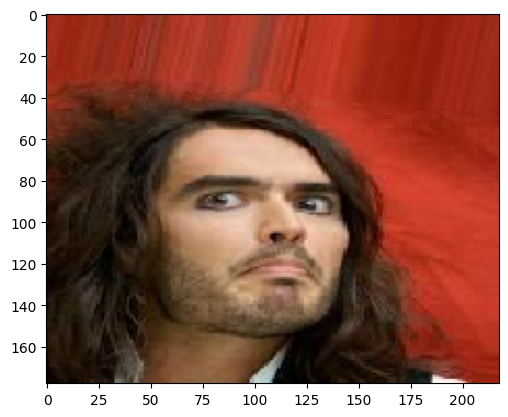

5_o_Clock_Shadow       0
Arched_Eyebrows        0
Attractive             1
Bags_Under_Eyes        0
Bald                   0
Bangs                  0
Big_Lips               0
Big_Nose               0
Black_Hair             0
Blond_Hair             0
Blurry                 0
Brown_Hair             0
Bushy_Eyebrows         1
Chubby                 0
Double_Chin            0
Eyeglasses             0
Goatee                 0
Gray_Hair              0
Heavy_Makeup           0
High_Cheekbones        0
Male                   1
Mouth_Slightly_Open    0
Mustache               0
Narrow_Eyes            0
No_Beard               0
Oval_Face              0
Pale_Skin              0
Pointy_Nose            0
Receding_Hairline      0
Rosy_Cheeks            0
Sideburns              0
Smiling                0
Straight_Hair          0
Wavy_Hair              0
Wearing_Earrings       0
Wearing_Hat            0
Wearing_Lipstick       0
Wearing_Necklace       0
Wearing_Necktie        0
Young                  1


5_o_Clock_Shadow       0
Arched_Eyebrows        0
Attractive             0
Bags_Under_Eyes        0
Bald                   0
Bangs                  0
Big_Lips               0
Big_Nose               0
Black_Hair             1
Blond_Hair             0
Blurry                 0
Brown_Hair             0
Bushy_Eyebrows         1
Chubby                 0
Double_Chin            0
Eyeglasses             0
Goatee                 0
Gray_Hair              0
Heavy_Makeup           0
High_Cheekbones        0
Male                   1
Mouth_Slightly_Open    0
Mustache               0
Narrow_Eyes            0
No_Beard               0
Oval_Face              0
Pale_Skin              0
Pointy_Nose            0
Receding_Hairline      0
Rosy_Cheeks            0
Sideburns              1
Smiling                0
Straight_Hair          0
Wavy_Hair              1
Wearing_Earrings       0
Wearing_Hat            0
Wearing_Lipstick       0
Wearing_Necklace       0
Wearing_Necktie        0
Young                  1


In [20]:
# print the image
image = test_generator.next()[0][0]
print(test_generator.filenames[0])
plt.imshow(image)
plt.show()

# rename columns
column_names = ['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young']

# use this to compare true labels vs predicted labels for a specific image (displayed above)
connections = pd.DataFrame(predicted_labels,columns=column_names[1:])
pd.set_option("display.max_columns",None)
display(connections.iloc[0]) #change indexes for diferent images

connections = pd.DataFrame(true_labels,columns=column_names[1:])
pd.set_option("display.max_columns",None) #change indexes for diferent images
display(connections.iloc[0])

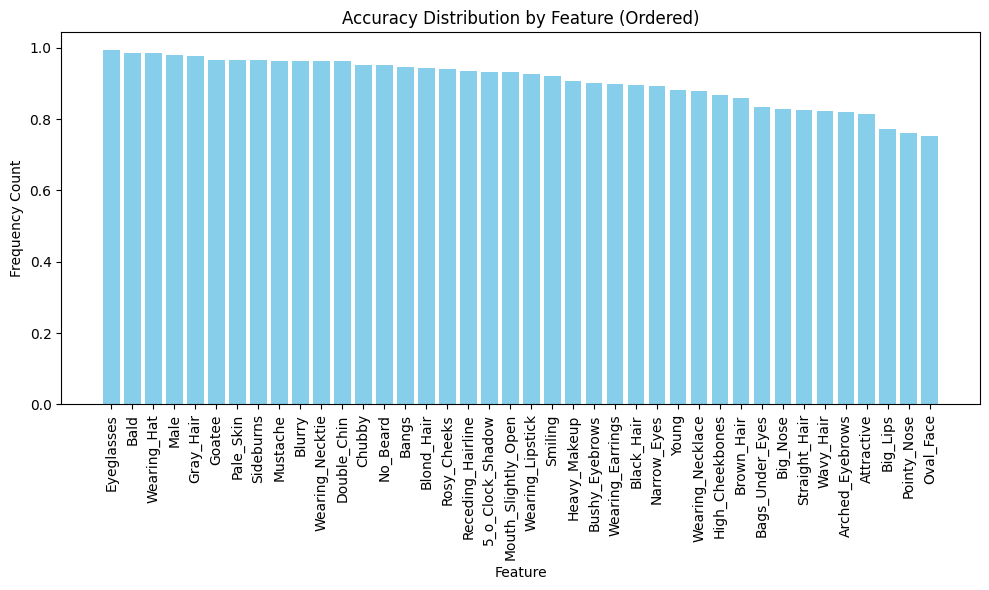

In [21]:
# Plot Accuracy histogram per feature

# Convert accuracy_by_feature dictionary to lists for plotting
features = list(accuracy_by_feature.keys())
accuracies = list(accuracy_by_feature.values())

# Sort features and accuracies by frequency count in descending order
sorted_indices = sorted(range(len(accuracies)), key=lambda k: accuracies[k], reverse=True)
sorted_features = [features[i] for i in sorted_indices]
sorted_accuracies = [accuracies[i] for i in sorted_indices]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.bar(sorted_features, sorted_accuracies, color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Frequency Count')
plt.title('Accuracy Distribution by Feature (Ordered)')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

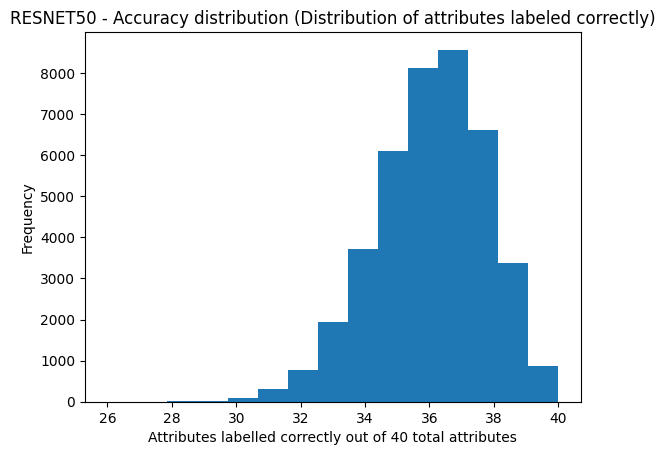

In [22]:
# Plot histogram of Attributes labelled correctly out of the 40

lr_correct_predictions = (true_labels == predicted_labels)
lr_samples_all_features_correct = np.sum(lr_correct_predictions.all(axis=1))

lr_correct_prediction_rows = pd.DataFrame(lr_correct_predictions.sum(axis=1))
lr_correct_prediction_rows.plot.hist(bins=15)
plt.title("RESNET50 - Accuracy distribution (Distribution of attributes labeled correctly)")
plt.legend().remove()
plt.xlabel("Attributes labelled correctly out of 40 total attributes");